# 01_srnn_go_nogo

In this notebook we prepare a very simple spiking RNN that is capable of performing a Go / NoGo task.

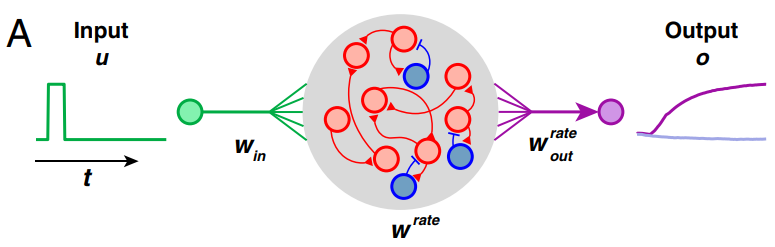

This is an attempt to reproduce parts of Fig 1 from [Kim, Li, and Sejnowski, PNAS, 2019](https://www.pnas.org/content/116/45/22811.short) using Nengo.

* Each network was trained to produce a positive mean population activity approaching +1 after a brief input pulse.
* For a trial without an input pulse (i.e., NoGo trial), the networks were trained to maintain the output signal close to 0.
* output(t) = W * R(t)  Where W is the readout weights and R is the recurrent network.
* 9 different network sizes from 10 to 400 neurons, each trained 100 times. 250 was best.
* synaptic time constants from 20 to 50 ms
* trained for up to 6000 trials

## Environment Setup

In [ ]:
#@title Run Environment Setup
try:
    # See if we are running on google.colab
    from google.colab import files
    IN_COLAB = True
    !pip install --upgrade nengo nengo-gui nbdev git+https://github.com/neuromorphs/grill-srnn-pfc.git
    !jupyter serverextension enable nengo_gui.jupyter
    # TODO: kaggle creds for downloading data 
    
except ModuleNotFoundError:
    IN_COLAB = False

%load_ext autoreload
%autoreload 2

## Task Stimulus Encoding

TODO:
* expected_response - output integral of input

In [ ]:
import numpy as np

n_trials_per_condition = 3000  # x 2 go-or-nogo
rng_seed = 1337
isi_dur = 0.25
cue_dur = 0.1
response_dur = 0.65
tau = 0.1

phase_durs = [isi_dur, cue_dur, response_dur]
cumulative_durs = np.cumsum(phase_durs)
trial_dur = cumulative_durs[-1]

# ISI period provides resetting inhibition
def isi(t):
    return (t % trial_dur) < isi_dur

trial_conds = np.tile(np.arange(2), n_trials_per_condition)
rng = np.random.default_rng(seed=rng_seed)
rng.shuffle(trial_conds)

def targ_signal(t):
    trial_ix = int(np.floor(t / trial_dur)) % len(trial_conds)
    cond_ix = trial_conds[trial_ix]
    if cond_ix:
        t_trial = t % trial_dur
        go_cue = t_trial >= cumulative_durs[0] and t_trial < cumulative_durs[1]
        return go_cue
    return 0

# Are we going to need this?
def expected_response(t):
    trial_ix = int(np.floor(t / trial_dur)) % len(trial_conds)
    cond_ix = trial_conds[trial_ix]
    if cond_ix:
        t_trial = t % trial_dur
        if t_trial >= cumulative_durs[0]:
            return 1 - np.exp(-(t_trial - cumulative_durs[0]) * 5.0)
    return 0

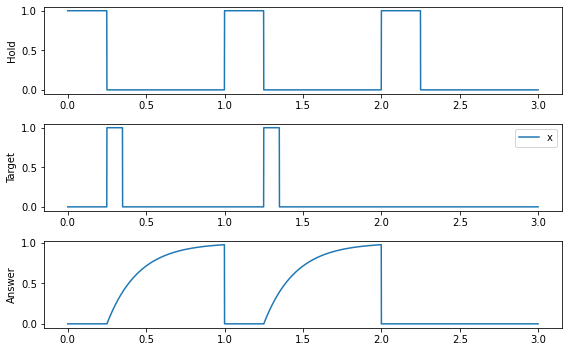

In [ ]:
import matplotlib.pyplot as plt

test_trials = 3
test_srate = 1000  # Hz
t_vec = np.arange(0, trial_dur * test_trials, 1 / test_srate)

plt.figure(figsize=(8, 5))
plt.subplot(3, 1, 1)
plt.plot(t_vec, isi(t_vec))
plt.ylabel('Hold')
plt.subplot(3, 1, 2)
plt.plot(t_vec, [targ_signal(_) for _ in t_vec])
plt.ylabel('Target')
plt.legend(['x', 'y'], loc='upper right')
plt.subplot(3, 1, 3)
plt.plot(t_vec, [expected_response(_) for _ in t_vec])
plt.ylabel('Answer')
plt.tight_layout()

## Model Setup

TODO:
* integrator: correctly parameterize its connections so it is a true integrator... but scale so that the relatively short input period (0.1) yields an integration == 1.0.
* Add option to train with an error signal compared to output.

In [ ]:
import nengo
import numpy as np

class GoNoGo(nengo.Network):
    def __init__(self, tau=0.1, n_neurons=250):
        # Input Nodes
        
        # Fixation: -1 except during response period.
        self.isi = nengo.Node(isi, size_out=1, label='isi')
        
        # Target: 1 during Cue period for Go trials. Otherwise 0.
        self.target = nengo.Node(targ_signal, size_out=1, label='target')
        
        # Known correct answer - not implemented yet
        self.answer = nengo.Node(expected_response, label='answer')
        
        # SNN to do the task
        self.integrator = nengo.Ensemble(n_neurons=n_neurons, dimensions=1, label='integrator')
        nengo.Connection(self.target, self.integrator, transform=tau)
        recurr = nengo.Connection(self.integrator, self.integrator,
                                  # function=lambda x: 1.3 * x,
                                  learning_rule_type=nengo.PES(learning_rate=1e-4),
                                  synapse=tau)
        nengo.Connection(self.isi, self.integrator.neurons, transform=[[-1]] * n_neurons)
        
        # error signal = output - answer
        self.error = nengo.Node(None, size_in=1, label='error')
        # self.error = nengo.Ensemble(100, dimensions=1, label='error')
        nengo.Connection(self.integrator, self.error)
        nengo.Connection(self.answer, self.error, transform=-1)
        nengo.Connection(self.error, recurr.learning_rule)

In [ ]:
from nengo_gui.ipython import IPythonViz

with nengo.Network() as inet:
    inet.gonogo = GoNoGo(tau=0.05, n_neurons=1000)
IPythonViz(inet)

In [ ]:
def test_gonogo(net, sim_trials=160):
    sim_time = sim_trials * trial_dur
    with net:
        net.gonogo = GoNoGo(tau=0.2, n_neurons=250)
        
        probes = {
            'isi': nengo.Probe(net.gonogo.isi),
            'targ': nengo.Probe(net.gonogo.target),
            'integrator': nengo.Probe(net.gonogo.integrator),
            'answer': nengo.Probe(net.gonogo.answer),
            'error': nengo.Probe(net.gonogo.error)
        }
    
    with nengo.Simulator(net) as sim:
        sim.run(sim_time)
    return sim, probes
    
net = nengo.Network()
sim, probes = test_gonogo(net)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

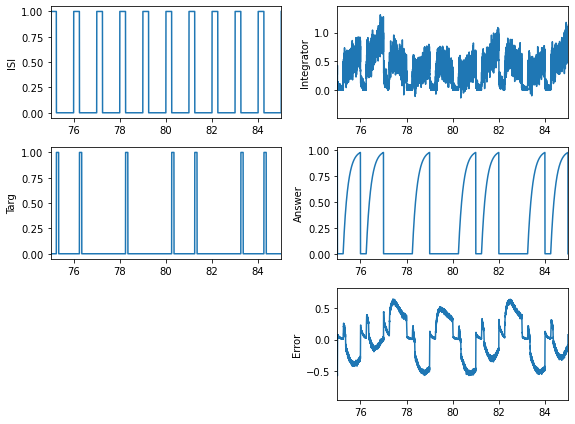

In [ ]:
t = sim.trange()
xrange = [trial_dur*75, trial_dur*85]

plt.figure(figsize=(8, 6))

plt.subplot(3, 2, 1)
plt.plot(t, sim.data[probes['isi']])
plt.xlim(xrange)
plt.ylabel('ISI')

plt.subplot(3, 2, 3)
plt.plot(t, sim.data[probes['targ']])
plt.xlim(xrange)
plt.ylabel('Targ')

plt.subplot(3, 2, 2)
plt.plot(t, sim.data[probes['integrator']])
plt.xlim(xrange)
plt.ylabel('Integrator')

plt.subplot(3, 2, 4)
plt.plot(t, sim.data[probes['answer']])
plt.xlim(xrange)
plt.ylabel('Answer')

plt.subplot(3, 2, 6)
plt.plot(t, sim.data[probes['error']])
plt.xlim(xrange)
plt.ylabel('Error')

plt.tight_layout()